In [23]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Take a look at the datasets
df = pd.read_csv("ex4-crimerates-by-state-2005.csv")
df.head()

,state,murder,forcible_rape,robbery,aggravated_assault,burglary,larceny_theft,motor_vehicle_theft,population
0,United States,5.6,31.7,140.7,291.1,726.7,2286.3,416.7,295753151
1,Alabama,8.2,34.3,141.4,247.8,953.8,2650.0,288.3,4545049
2,Alaska,4.8,81.1,80.9,465.1,622.5,2599.1,391.0,669488
3,Arizona,7.5,33.8,144.4,327.4,948.4,2965.2,924.4,5974834
4,Arkansas,6.7,42.9,91.1,386.8,1084.6,2711.2,262.1,2776221


***Scatterplot***

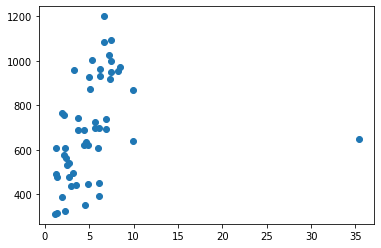

In [4]:
# Initial Scatterplot
plt.scatter(df.murder, df.burglary)

In [13]:
# Remove outlier and United States averages
df2 = df[(df.state != "District of Columbia") & (df.state != "United States")]

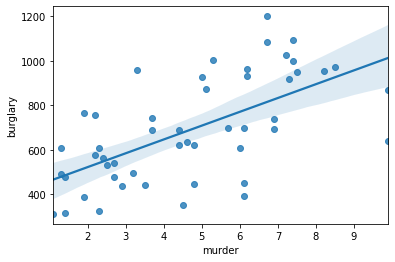

In [19]:
# Plot the cleaned up data with a regression line
ax = sns.regplot(x="murder", y="burglary", data=df2)

In [25]:
# Copied some dunctions from online that someone used to create a LOESS curve in Python
import scipy

def loc_eval(x, b):
    """
    Evaluate `x` using locally-weighted regression parameters.
    Degree of polynomial used in loess is inferred from b. `x`
    is assumed to be a scalar.
    """
    loc_est = 0
    for i in enumerate(b): loc_est+=i[1]*(x**i[0])
    return(loc_est)

def loess(xvals, yvals, alpha, poly_degree=1):
    """
    Perform locally-weighted regression on xvals & yvals.
    Variables used inside `loess` function:

        n         => number of data points in xvals
        m         => nbr of LOESS evaluation points
        q         => number of data points used for each
                     locally-weighted regression
        v         => x-value locations for evaluating LOESS
        locsDF    => contains local regression details for each
                     location v
        evalDF    => contains actual LOESS output for each v
        X         => n-by-(poly_degree+1) design matrix
        W         => n-by-n diagonal weight matrix for each
                     local regression
        y         => yvals
        b         => local regression coefficient estimates.
                     b = `(X^T*W*X)^-1*X^T*W*y`. Note that `@`
                     replaces `np.dot` in recent numpy versions.
        local_est => response for local regression
    """
    # Sort dataset by xvals.
    all_data = sorted(zip(xvals, yvals), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)

    locsDF = pd.DataFrame(
                columns=[
                  'loc','x','weights','v','y','raw_dists',
                  'scale_factor','scaled_dists'
                  ])
    evalDF = pd.DataFrame(
                columns=[
                  'loc','est','b','v','g'
                  ])

    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
    avg_interval = ((max(xvals)-min(xvals))/len(xvals))
    v_lb = max(0,min(xvals)-(.5*avg_interval))
    v_ub = (max(xvals)+(.5*avg_interval))
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)

    # Generate design matrix based on poly_degree.
    xcols = [np.ones_like(xvals)]
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    X = np.vstack(xcols).T


    for i in v:

        iterpos = i[0]
        iterval = i[1]

        # Determine q-nearest xvals to iterval.
        iterdists = sorted([(j, np.abs(j-iterval)) \
                           for j in xvals], key=lambda x: x[1])

        _, raw_dists = zip(*iterdists)

        # Scale local observations by qth-nearest raw_dist.
        scale_fact = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        weights = [(j[0],((1-np.abs(j[1]**3))**3 \
                      if j[1]<=1 else 0)) for j in scaled_dists]

        # Remove xvals from each tuple:
        _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
        _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
        _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))

        iterDF1 = pd.DataFrame({
                    'loc'         :iterpos,
                    'x'           :xvals,
                    'v'           :iterval,
                    'weights'     :weights,
                    'y'           :yvals,
                    'raw_dists'   :raw_dists,
                    'scale_fact'  :scale_fact,
                    'scaled_dists':scaled_dists
                    })

        locsDF    = pd.concat([locsDF, iterDF1])
        W         = np.diag(weights)
        y         = yvals
        b         = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)
        local_est = loc_eval(iterval, b)
        iterDF2   = pd.DataFrame({
                       'loc':[iterpos],
                       'b'  :[b],
                       'v'  :[iterval],
                       'g'  :[local_est]
                       })

        evalDF = pd.concat([evalDF, iterDF2])

    # Reset indicies for returned DataFrames.
    locsDF.reset_index(inplace=True)
    locsDF.drop('index', axis=1, inplace=True)
    locsDF['est'] = 0; evalDF['est'] = 0
    locsDF = locsDF[['loc','est','v','x','y','raw_dists',
                     'scale_fact','scaled_dists','weights']]

    # Reset index for evalDF.
    evalDF.reset_index(inplace=True)
    evalDF.drop('index', axis=1, inplace=True)
    evalDF = evalDF[['loc','est', 'v', 'b', 'g']]

    return(locsDF, evalDF)

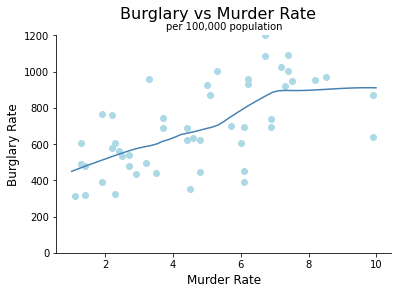

In [46]:
# loess function returns regsDF and evalDF for "Regression DataFrame" and "Evaluation DataFrame"
regsDF, evalDF = loess(df2.murder, df2.burglary, alpha=.6, poly_degree=1)

# Obtain reference to LOESS x & y values (v & g).
l_x  = evalDF['v'].values
l_y  = evalDF['g'].values

# Generate x-y scatterplot with loess estimate overlaid.
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Remove the right border
right = ax1.spines["right"]
right.set_visible(False)

# Remove the top border
top = ax1.spines["top"]
top.set_visible(False)

ax1.scatter(df2.murder, df2.burglary, label="Original Data", color="lightblue")
ax1.plot(l_x, l_y, color='steelblue', label="1st-degree Polynomial LOESS")
ax1.set_title("per 100,000 population", fontsize=10)
fig.suptitle("Burglary vs Murder Rate\n", fontsize=16)
ax1.set_xlabel("Murder Rate", size=12)
ax1.set_ylabel("Burglary Rate", size=12)
ax1.set_ylim(0,1200,200)

plt.show()

***Bubble Chart***

(0.0, 11.0)

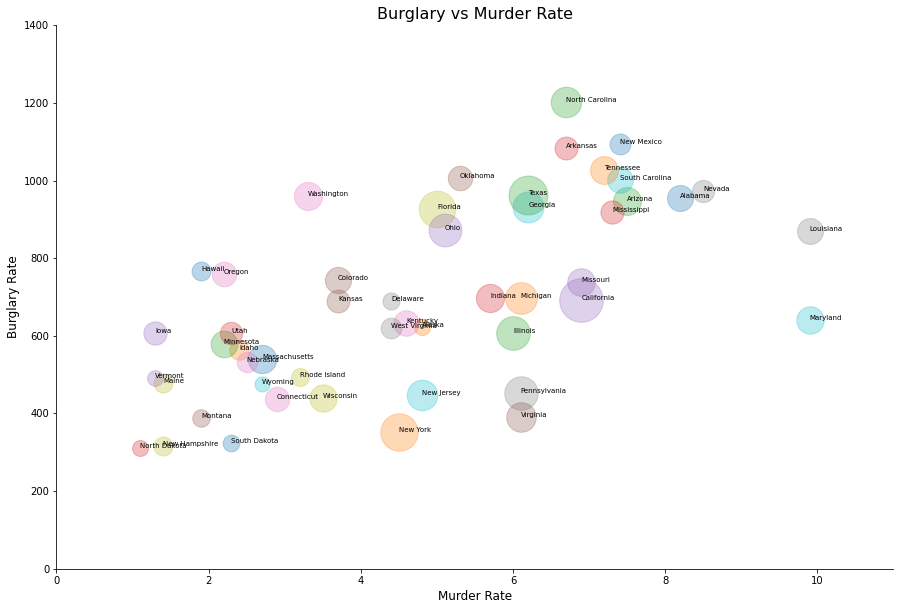

In [136]:
# Create the bubble chart
fig, ax = plt.subplots()

# Define figure size
figsize = (15, 10)

# Remove the right border
right = ax.spines["right"]
right.set_visible(False)

# Remove the top border
top = ax.spines["top"]
top.set_visible(False)

# Iterate through the dataframe and pull out the points and labels for each bubble
for key, row in df2.iterrows():
    ax.scatter(row['murder'], row['burglary'], s=row['population'] ** 0.5 / pi, alpha=.3)
    ax.annotate(row['state'], xy=(row['murder'], row['burglary']), fontsize='x-small')
    
# Title, lables, limits
plt.title("Burglary vs Murder Rate", fontsize=16)
plt.xlabel("Murder Rate", size=12)
plt.ylabel("Burglary Rate", size=12)
plt.ylim(0,1400,200)
plt.xlim(0,11)

***Density Plot***

In [138]:
# Take a look at the datasets
birth = pd.read_csv("ex4-birth-rate.csv")
birth.head()

,Country,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
0,Aruba,36.400,35.179,33.863,32.459,30.994,29.513,28.069,26.721,25.518,...,15.024,14.528,14.041,13.579,13.153,12.772,12.441,12.159,11.919,11.716
1,Afghanistan,52.201,52.206,52.208,52.204,52.192,52.168,52.130,52.076,52.006,...,51.229,50.903,50.486,49.984,49.416,48.803,48.177,47.575,47.023,46.538
2,Angola,54.432,54.394,54.317,54.199,54.040,53.836,53.585,53.296,52.984,...,48.662,48.355,48.005,47.545,46.936,46.184,45.330,44.444,43.607,42.875
3,Albania,40.886,40.312,39.604,38.792,37.913,37.008,36.112,35.245,34.421,...,17.713,16.850,16.081,15.444,14.962,14.644,14.485,14.464,14.534,14.649
4,Netherlands Antilles,32.321,30.987,29.618,28.229,26.849,25.518,24.280,23.173,22.230,...,15.809,15.412,15.096,14.824,14.565,14.309,14.051,13.790,13.532,13.281


In [143]:
# Drop rows with na values from the year 2008
birth["2008"].dropna(inplace=True)

C:\Users\myraw\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(31, 0.032, 'The median birth rate was 19 live births per 1,000 population')

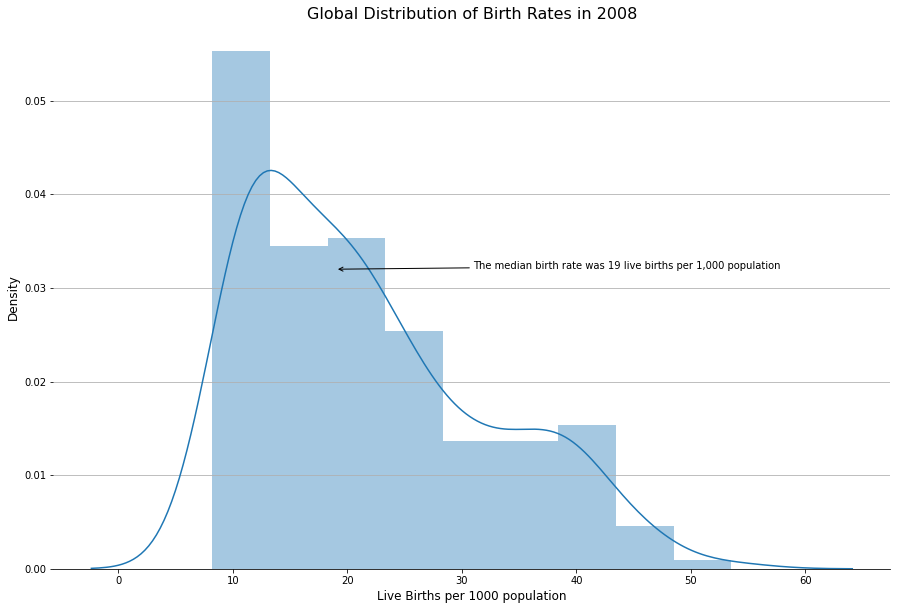

In [152]:
# Density plot
fig, ax = plt.subplots()

# Remove the right border
right = ax.spines["right"]
right.set_visible(False)

# Remove the top border
top = ax.spines["top"]
top.set_visible(False)

# Remove left border
left = ax.spines["left"]
left.set_visible(False)

# Use seaborn to plot the density of births during 2008
sns.distplot(birth["2008"])

# Title, lables, limits
plt.title("Global Distribution of Birth Rates in 2008", fontsize=16)
plt.xlabel("Live Births per 1000 population", size=12)
plt.ylabel("Density", size=12)
plt.grid(axis='y')

plt.annotate("The median birth rate was 19 live births per 1,000 population", xy=(19, 0.032), xytext=(31, 0.032), 
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

